In [1]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np
%matplotlib inline

In [2]:
class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU()
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))
    




In [3]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(4).cuda() # construct Lenet for 3 class classification, use GPU
blob.criterionPID = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.alpha = 1e-5
blob.criterionE = torch.nn.MSELoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters(),weight_decay=0.001) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.dirs      = None
blob.labelPID     = None # label for training/analysis
blob.labelE = None

In [4]:
# Create data loader
from iotools import loader_factory
DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']
label = "Nominal_10_epochs_huberLoss_EkinAboveThr"
#DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE_globalChargeShift_1.05/e-','/data/hkml_data/IWCDgrid/varyE_globalChargeShift_1.05/mu-','/data/hkml_data/IWCDgrid/varyE_globalChargeShift_1.05/gamma']
#label = "GlobalQscale"

# for validation
#DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE_randomTubeChargeScale_0.2_1.1/e-','/data/hkml_data/IWCDgrid/varyE_randomTubeChargeScale_0.2_1.1/mu-','/data/hkml_data/IWCDgrid/varyE_randomTubeChargeScale_0.2_1.1/gamma']
#label = "RandomTubeQScale"
blob.test_loader=loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.2, use_fraction=0.1, read_keys=["energies", "directions"])

#DATA_DIRS_GLOBAL_SHIFT=['/data/hkml_data/IWCDgrid/varyE_globalChargeShift_1.05/e-','/data/hkml_data/IWCDgrid/varyE_globalChargeShift_1.05/mu-','/data/hkml_data/IWCDgrid/varyE_globalChargeShift_1.05/gamma']
# for validation
#blob.test_loader_global_shift=loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.2, use_fraction=0.1, read_keys=["energies", "directions"])

In [5]:
#blob.net.load_state_dict(torch.load("/data/cvilela/ExampleNotebooks/fullDataSet_50epochs.cnn"))
blob.net.load_state_dict(torch.load("cvn_10epochs_huberloss_EkinAboveThr.cnn"))

In [6]:
from classification import inference
accuracy, labelPID, predictionPID,labelE, predictionE, dirs = inference(blob,blob.test_loader)

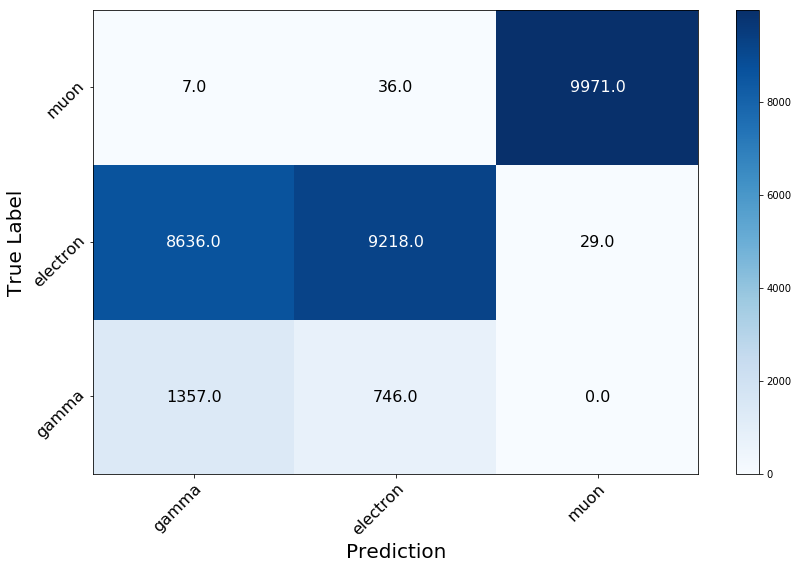

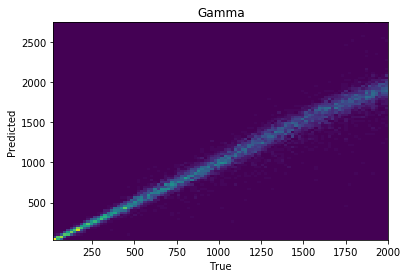

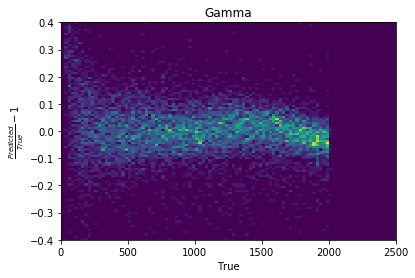

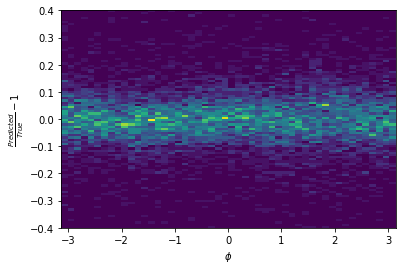

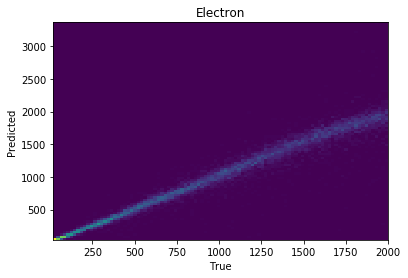

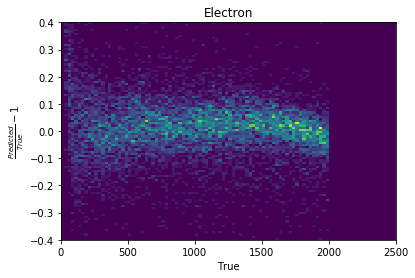

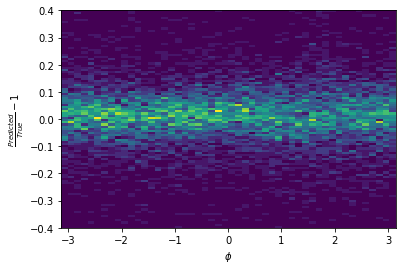

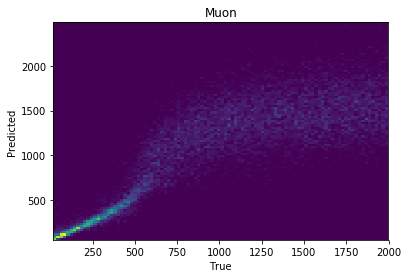

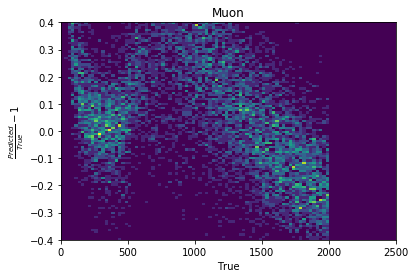

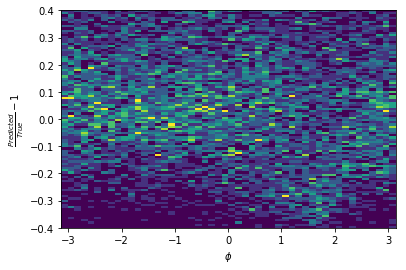

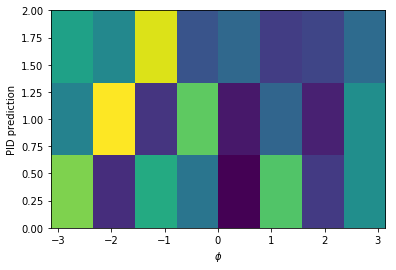

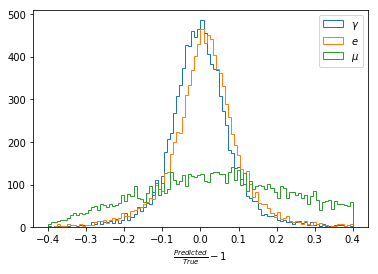

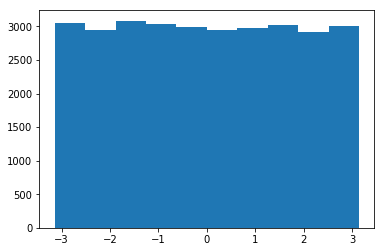

In [7]:
import matplotlib.pyplot as plt


maskGamma = labelPID == 0
maskElectron = labelPID == 1
maskMuon = labelPID == 2

from utils import plot_confusion_matrix
fig = plot_confusion_matrix(labelPID,predictionPID,['gamma','electron','muon'])
plt.savefig("cnn_50epochs_"+label+"_Confusion.pdf")
plt.savefig("cnn_50epochs_"+label+"_Confusion.png")
plt.show()


phi = np.array([np.arctan2(d[0][0],d[0][2]) for d in dirs])

for i in [["Gamma", maskGamma],
          ["Electron", maskElectron],
        ["Muon", maskMuon]] :
    
    plt.hist2d(x = labelE[i[1]], y = predictionE[i[1]], bins = 100)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(i[0])
    plt.savefig("cnn_50epochs_"+label+"_"+i[0]+"_EtrueErec.pdf")
    plt.savefig("cnn_50epochs_"+label+"_"+i[0]+"_EtrueErec.png")
    plt.show()

    plt.hist2d(x = labelE[i[1]], y = predictionE[i[1]]/labelE[i[1]]-1., bins = 100, range = ((0, 2500), (-0.4, 0.4)))
    plt.xlabel("True")
    plt.ylabel(r"$\frac{Predicted}{True}-1$")
    plt.title(i[0])
    plt.savefig("cnn_50epochs_"+label+"_"+i[0]+"_EtrueErecFrac.pdf")
    plt.savefig("cnn_50epochs_"+label+"_"+i[0]+"_EtrueErecFrac.png")
    plt.show()

    
    plt.hist2d(x= phi[i[1]], y = predictionE[i[1]]/labelE[i[1]]-1., bins = (50,100), range = ((-np.pi, np.pi), (-0.4, 0.4)))
    plt.xlabel("$\phi$")
    plt.ylabel(r"$\frac{Predicted}{True}-1$")
    plt.savefig("cnn_50epochs_"+label+"_"+i[0]+"_phiErecFrac.pdf")
    plt.savefig("cnn_50epochs_"+label+"_"+i[0]+"_phiErecFrac.png")
    plt.show()
    
plt.hist2d(x= phi, y = labelPID, bins = (8,3), range = ((-np.pi, np.pi), (0, 2)))
plt.xlabel("$\phi$")
plt.ylabel(r"PID prediction")
plt.savefig("cnn_50epochs_"+label+"_phiPID.pdf")
plt.savefig("cnn_50epochs_"+label+"_phiPID.png")
plt.show()


plt.hist(predictionE[maskGamma]/labelE[maskGamma]-1., bins = 100, range = (-0.4, 0.4), histtype="step", label=r"$\gamma$")
plt.hist(predictionE[maskElectron]/labelE[maskElectron]-1., bins = 100, range = (-0.4, 0.4), histtype="step", label=r"$e$")
plt.hist(predictionE[maskMuon]/labelE[maskMuon]-1., bins = 100, range = (-0.4, 0.4), histtype="step", label=r"$\mu$")

plt.xlabel(r"$\frac{Predicted}{True}-1$")

plt.legend()

#plt.savefig("cnn_50epochs_varyE_EtrueErecProj.pdf")
#plt.savefig("cnn_50epochs_varyE_EtrueErecProj.png")
plt.savefig("cnn_50epochs_"+label+"_ErecResolution.pdf")
plt.savefig("cnn_50epochs_"+label+"_ErecResolution.png")

plt.show()


plt.hist(phi)
plt.show()